In [1]:
!pip install proxbias -U --quiet

In [2]:
import os
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import sklearn
from sklearn.utils import Bunch

from proxbias import utils as utils
import proxbias as pb

# This is necesary for the svg output plots to have editable text
plt.rcParams['svg.fonttype'] = 'none'

# Just to make the notebook take up full screen real estate, not necessary
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Functions

In [3]:
from typing import List, Tuple

# cnv_loss_cutoff = 0.805  # 0.6 copies and below
# cnv_gain_cutoff = 1.026  # 3.8 copies and above
cnv_absolute_loss_cutoff = 1.5
cnv_absolute_gain_cutoff = 2.25

# Maybe move this to a function in the repo
def split_models(
    gene_symbol: str,
    candidate_models: List[str],
    cnv_data: pd.DataFrame,
    mutation_data: pd.DataFrame,
    cutoffs: Tuple[float, float] = (cnv_absolute_loss_cutoff, cnv_absolute_gain_cutoff),
) -> Tuple[List[str], List[str], List[str], List[str]]:
    mutant_lines = mutation_data.loc[(
        (mutation_data["HugoSymbol"] == gene_symbol) &
        (~mutation_data["VariantInfo"].isna()) # Not using the mutant type information
    ),'ModelID'].unique().tolist()
    wild_type = list(set(candidate_models).difference(mutant_lines))
    mutants = list(set(candidate_models).difference(wild_type))

    cnv_subset = (np.power(2, cnv_data.loc[gene_symbol]) - 1) * 2
    # wt_cnv = cnv_subset.loc[cnv_subset.index.intersection(wild_type)]
    all_cnv = cnv_subset.loc[cnv_subset.index.intersection(candidate_models)]
    lof = list(set(candidate_models).intersection(all_cnv.loc[all_cnv < cutoffs[0]].index.unique()))
    gof = list(set(candidate_models).intersection(all_cnv.loc[all_cnv >= cutoffs[1]].index.unique()))
    mutant_low_change = set(candidate_models).difference(set(lof) | set(gof) | set(wild_type))
    wt_low_change = set(wild_type).difference(set(lof) | set(gof))
    return list(lof), list(wt_low_change), list(gof), list(mutant_low_change)

# Load in DepMap cell line annotation data (CNV & mutations)


In [4]:
data_dir = '../data'
cnv_file = os.path.join(data_dir, "OmicsCNGene.csv")
cnv_data = pd.read_csv(cnv_file).rename(columns={"Unnamed: 0": "ModelID"}).set_index("ModelID").T
cnv_data.index = [g.split(" ")[0] for g in cnv_data.index]  # remove entrez gene ids

mutation_file = "OmicsSomaticMutations.csv"
mutation_data = pd.read_csv(os.path.join(data_dir, mutation_file)).rename(columns={"DepMap_ID": "ModelID"})

/tmp/ipykernel_2742091/924039965.py:7: DtypeWarning: Columns (32,40,48,49,50,51,53) have mixed types. Specify dtype option on import or set low_memory=False.
  mutation_data = pd.read_csv(os.path.join(data_dir, mutation_file)).rename(columns={"DepMap_ID": "ModelID"})


# Load in the 22Q4 DepMap data 

See notes in the README on how to download and process this data.

In [5]:
dm22q4 = pd.read_csv(os.path.join(data_dir, 'depmap_22q4_embeddings.csv'), index_col='Unnamed: 0')
dm22q4.index.name = 'gene'

In [6]:
dm22q4.head(2)

ACH-000004  ACH-000005  ACH-000007  ACH-000009  ACH-000011  \
gene                                                                 
SAMD11    0.138971   -0.024604    0.164436   -0.135659    0.181989   
NOC2L    -0.337622    0.298930   -0.277252   -0.199345    0.045464   

        ACH-000012  ACH-000013  ACH-000014  ACH-000015  ACH-000017  ...  \
gene                                                                ...   
SAMD11   -0.007635    0.050045   -0.001966     0.05847   -0.058567  ...   
NOC2L    -0.445447    0.153700   -0.053124     0.14612   -0.107405  ...   

        ACH-002283  ACH-002284  ACH-002285  ACH-002294  ACH-002295  \
gene                                                                 
SAMD11    0.132243   -0.130717   -0.148272    0.133393   -0.030585   
NOC2L    -0.033149   -0.023406   -0.285678    0.009905   -0.110960   

        ACH-002296  ACH-002297  ACH-002298  ACH-002304  ACH-002305  
gene                                                                
SAMD11    0.042350    0.046475    0.086503    -0.05088    0.187428  
NOC2L    -0.309166   -0.058206   -0.188165    -0.59778    0.065761  

[2 rows x 1078 columns]

# Add in chromosome position information

In [7]:
gene_dict, chrom_dict, band_dict = utils.chromosome_info.get_chromosome_info_as_dicts()
genes = list(gene_dict.keys())

In [8]:
# Subset to genes with chrom information from hg38
idx = dm22q4.query(f"gene.isin({genes})").index
print(f'Full data has {dm22q4.shape[0]} genes, {len(idx)} of which are in annotations')
dm22q4 = dm22q4.loc[idx]

# Add in chromomsome information
def _add_chr_info(df, gene_dict, in_nm, out_nm):
    df[out_nm] = dm22q4.index.to_frame().gene.apply(lambda x: gene_dict[x][in_nm] if x in gene_dict else "no_info")
    return df

old_cols = dm22q4.columns.tolist()
dm22q4 = _add_chr_info(dm22q4, gene_dict, 'chrom', 'chromosome')
dm22q4 = _add_chr_info(dm22q4, gene_dict, 'chrom_int', 'chr_idx')
dm22q4 = _add_chr_info(dm22q4, gene_dict, 'arm', 'chromosome_arm')
dm22q4 = _add_chr_info(dm22q4, gene_dict, 'start', 'gene_bp')

cols = ['gene', 'chromosome', 'chr_idx', 'chromosome_arm', 'gene_bp']
dm22q4 = dm22q4.reset_index().set_index(cols)

Full data has 17408 genes, 17396 of which are in annotations


In [9]:
dm22q4.head(2)

ACH-000004  ACH-000005  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922     0.138971   -0.024604   
NOC2L  chr1       1       chr1p          944202    -0.337622    0.298930   

                                                  ACH-000007  ACH-000009  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922     0.164436   -0.135659   
NOC2L  chr1       1       chr1p          944202    -0.277252   -0.199345   

                                                  ACH-000011  ACH-000012  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922     0.181989   -0.007635   
NOC2L  chr1       1       chr1p          944202     0.045464   -0.445447   

                                                  ACH-000013  ACH-000014  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922     0.050045   -0.001966   
NOC2L  chr1       1       chr1p          944202     0.153700   -0.053124   

                                                  ACH-000015  ACH-000017  ...  \
gene   chromosome chr_idx chromosome_arm gene_bp                          ...   
SAMD11 chr1       1       chr1p          923922      0.05847   -0.058567  ...   
NOC2L  chr1       1       chr1p          944202      0.14612   -0.107405  ...   

                                                  ACH-002283  ACH-002284  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922     0.132243   -0.130717   
NOC2L  chr1       1       chr1p          944202    -0.033149   -0.023406   

                                                  ACH-002285  ACH-002294  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922    -0.148272    0.133393   
NOC2L  chr1       1       chr1p          944202    -0.285678    0.009905   

                                                  ACH-002295  ACH-002296  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922    -0.030585    0.042350   
NOC2L  chr1       1       chr1p          944202    -0.110960   -0.309166   

                                                  ACH-002297  ACH-002298  \
gene   chromosome chr_idx chromosome_arm gene_bp                           
SAMD11 chr1       1       chr1p          923922     0.046475    0.086503   
NOC2L  chr1       1       chr1p          944202    -0.058206   -0.188165   

                                                  ACH-002304  ACH-002305  
gene   chromosome chr_idx chromosome_arm gene_bp                          
SAMD11 chr1       1       chr1p          923922     -0.05088    0.187428  
NOC2L  chr1       1       chr1p          944202     -0.59778    0.065761  

[2 rows x 1078 columns]

# Split cell lines by TP53 function (WT, LOF, GOF) and calculate Brunner-Munzel statistics

In [10]:
from proxbias.utils.df_tools import make_pairwise_cos, make_split_cosmat
from proxbias.utils.q_norm import q_norm
from proxbias.plotting.heatmaps import plot_heatmap

In [11]:
tp53_lof_models, tp53_wt_models, tp53_gof_models, _ = split_models(
    gene_symbol="TP53",
    candidate_models=dm22q4.columns,
    cnv_data=cnv_data,
    mutation_data=mutation_data
)
print('TP53 LoF:', len(tp53_lof_models))
print('TP53 GoF:', len(tp53_gof_models))
print('TP53 WT:', len(tp53_wt_models))

TP53 LoF: 277
TP53 GoF: 164
TP53 WT: 245


In [12]:
# Make square dataframes of cosine similarities
tp53_lof_mat = make_pairwise_cos(dm22q4.loc[:,tp53_lof_models])
tp53_gof_mat = make_pairwise_cos(dm22q4.loc[:,tp53_gof_models])
tp53_wt_mat = make_pairwise_cos(dm22q4.loc[:,tp53_wt_models])

In [13]:
# Quantile normalize (so distributions are comparable)
tp53_lof_mat_norm = q_norm(tp53_lof_mat)
tp53_gof_mat_norm = q_norm(tp53_gof_mat)
tp53_wt_mat_norm = q_norm(tp53_wt_mat)

# Make a full-genome split heatmap of TP53 WT vs TP53 LOF

In [14]:
path = 'plots'
if not os.path.exists(path):
    os.mkdir(path)

DepMap 22Q4q3 quantile normalized - TP53 WT (upper) LoF (lower)


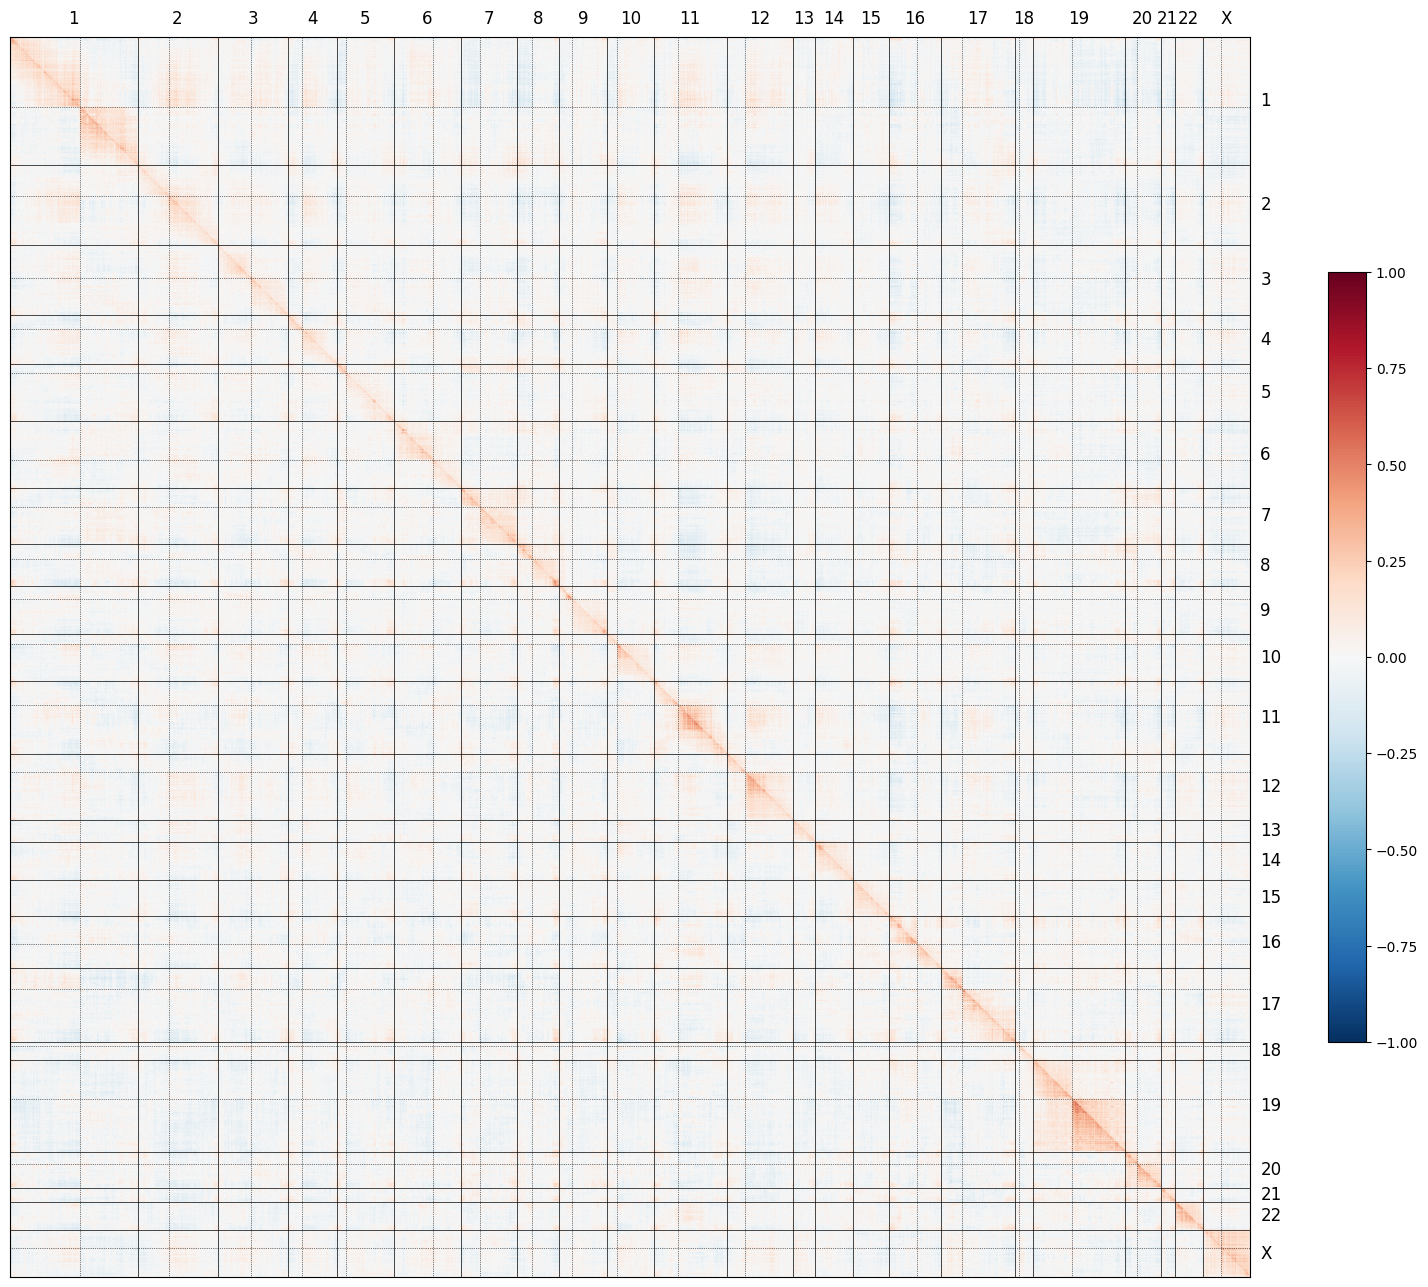

In [15]:
split_mat_norm = make_split_cosmat(tp53_wt_mat_norm, tp53_lof_mat_norm)
print('DepMap 22Q4q3 quantile normalized - TP53 WT (upper) LoF (lower)')
plot_heatmap(split_mat_norm, f_name=os.path.join(path, 'DepMap_22Q4_TP53_split_wt_vs_lof.svg'), format='svg', crunch_factor=10, title='')

# Quantify the proximity bias with Brunner-Munzel statistics

In [16]:
from proxbias.metrics import bm_metrics
from proxbias.plotting.bm_bars import plot_bm_bar_pairs

In [17]:
# Setting sample fraction helps avoid memory issues
tp53_wt_bm_all, tp53_wt_bm_arm = bm_metrics(tp53_wt_mat_norm, verbose=False, sample_frac=0.1)
tp53_lof_bm_all, tp53_lof_bm_arm = bm_metrics(tp53_lof_mat_norm, verbose=False, sample_frac=0.1)

In [18]:
tmp1 = tp53_wt_bm_arm.copy()
tmp1.index.name = 'Chromosome arm'
tmp1 = tmp1.assign(Condition = 'TP53 WT')
tmp1 = tmp1.reset_index().set_index(['Condition', 'Chromosome arm'])

tmp2 = tp53_lof_bm_arm.copy()
tmp2.index.name = 'Chromosome arm'
tmp2 = tmp2.assign(Condition = 'TP53 LoF')
tmp2 = tmp2.reset_index().set_index(['Condition', 'Chromosome arm'])

arm_stats_df = pd.concat([tmp1, tmp2])

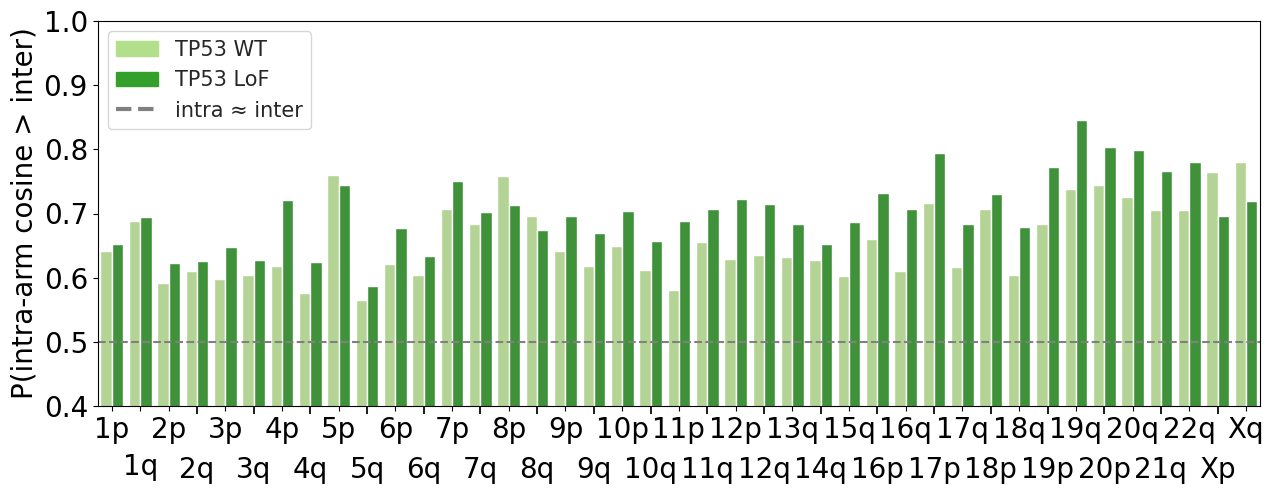

In [19]:
tmp = arm_stats_df
tmp = tmp.reset_index().rename(columns={'prob':'P(intra-arm cosine > inter)'})
tmp = pd.concat([tmp.query('Condition=="TP53 WT"'),
                 tmp.query('Condition=="TP53 LoF"')])
plot_bm_bar_pairs(tmp, x='Chromosome arm', y='P(intra-arm cosine > inter)', hue='Condition', 
                  lab1='TP53 WT', lab2='TP53 LoF', i=1, legend_loc='upper left',
                  f_name=os.path.join(path, 'tp53_split_bars.svg'))

# Look at the difference in prox bias for selected genes in the TP53 LoF background

In [20]:
sel_genes = [('CDKN2A', 'lof_vs_wt'),
             ('CDKN2B', 'lof_vs_wt'),
             ('CDKN2C', 'gof_vs_wt'),
             ('MDM4', 'gof_vs_wt'),
             ('BTG2', 'gof_vs_wt')]

In [21]:
def split_norm_mats(gene, tp53_bg_cl, split_type='lof_vs_wt',
                    cnv_data=cnv_data, mutation_data=mutation_data):
    lof_models, wt_models, gof_models, _ = split_models(
        gene_symbol=g,
        candidate_models=tp53_bg_cl,
        cnv_data=cnv_data,
        mutation_data=mutation_data
    )

    if split_type in ('lof_vs_wt', 'lof_vs_gof'):
        mat1 = make_pairwise_cos(dm22q4.loc[:,lof_models])

    if split_type == 'gof_vs_wt':
        mat1 = make_pairwise_cos(dm22q4.loc[:,gof_models])

    if split_type in ('lof_vs_wt', 'gof_vs_wt'):
        mat2 = make_pairwise_cos(dm22q4.loc[:,wt_models])

    if split_type == 'lof_vs_gof':
        mat2 = make_pairwise_cos(dm22q4.loc[:,gof_models])

    return mat1, mat2

In [22]:
arm_stats_d = {}

In [23]:
bg = 'p53_lof'
for g, split_type in sel_genes:
    print(g, split_type)
    if (g, split_type) in arm_stats_d:
        continue
    if bg == 'p53_lof':
        models = tp53_lof_models
    if bg == 'p53_wt':
        models = tp53_wt_models

    if split_type == 'lof_vs_wt':
        lab1 = f'{g} LOF'
        lab2 = f'{g} WT'
    if split_type == 'gof_vs_wt':
        lab1 = f'{g} GOF'
        lab2 = f'{g} WT'

    mat1_norm, mat2_norm = split_norm_mats(gene=g, tp53_bg_cl=models, split_type=split_type)

    mat1_bm_all, mat1_bm_arm = bm_metrics(mat1_norm, verbose=False, sample_frac=0.1)
    mat2_bm_all, mat2_bm_arm = bm_metrics(mat2_norm, verbose=False, sample_frac=0.1)

    tmp1 = mat1_bm_arm.copy()
    tmp1.index.name = 'Chromosome arm'
    tmp1 = tmp1.assign(Condition = lab1)
    tmp1 = tmp1.reset_index().set_index(['Condition', 'Chromosome arm'])

    tmp2 = mat2_bm_arm.copy()
    tmp2.index.name = 'Chromosome arm'
    tmp2 = tmp2.assign(Condition = lab2)
    tmp2 = tmp2.reset_index().set_index(['Condition', 'Chromosome arm'])

    arm_stats_df_tmp = pd.concat([tmp1, tmp2])
    arm_stats_d[(g, split_type)] = [arm_stats_df_tmp, mat1_bm_all, mat2_bm_all]
    print('done w/ analysis')

CDKN2A lof_vs_wt
done w/ analysis
CDKN2B lof_vs_wt
done w/ analysis
CDKN2C gof_vs_wt
done w/ analysis
MDM4 gof_vs_wt
done w/ analysis
BTG2 gof_vs_wt
done w/ analysis


CDKN2A lof_vs_wt
CDKN2B lof_vs_wt
CDKN2C gof_vs_wt
MDM4 gof_vs_wt
BTG2 gof_vs_wt


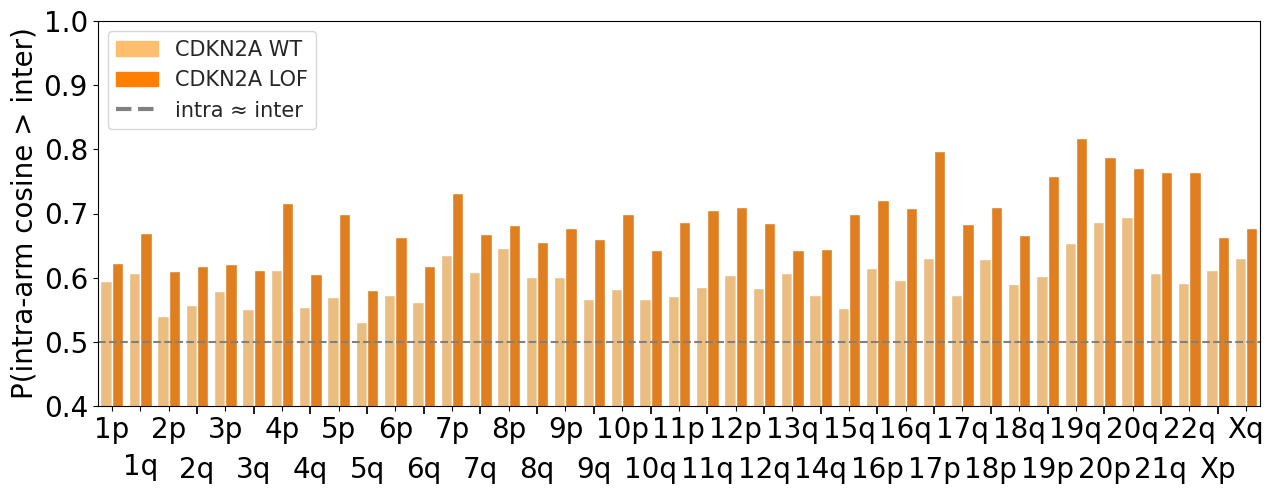

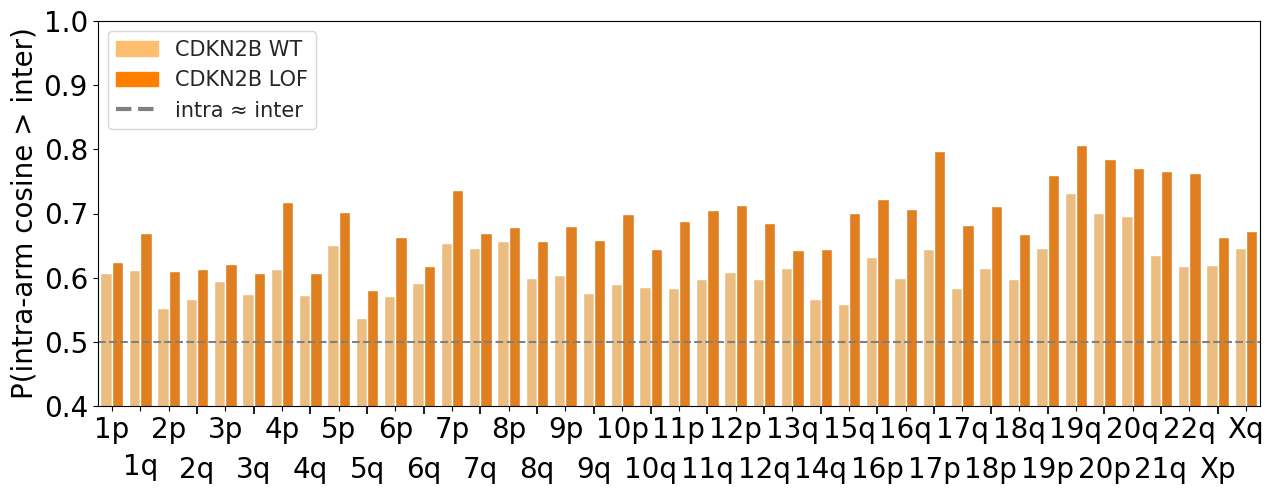

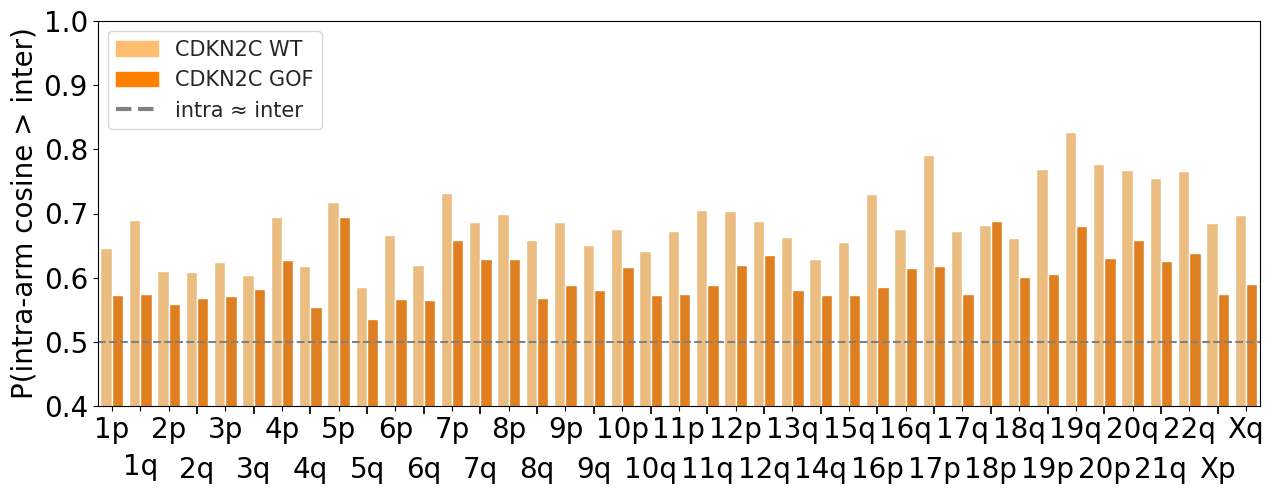

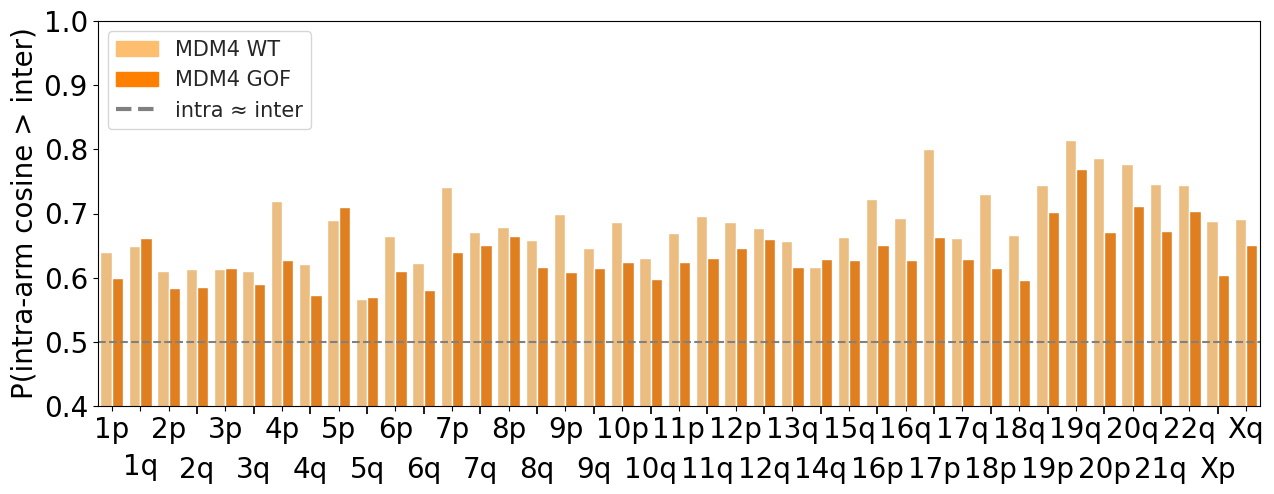

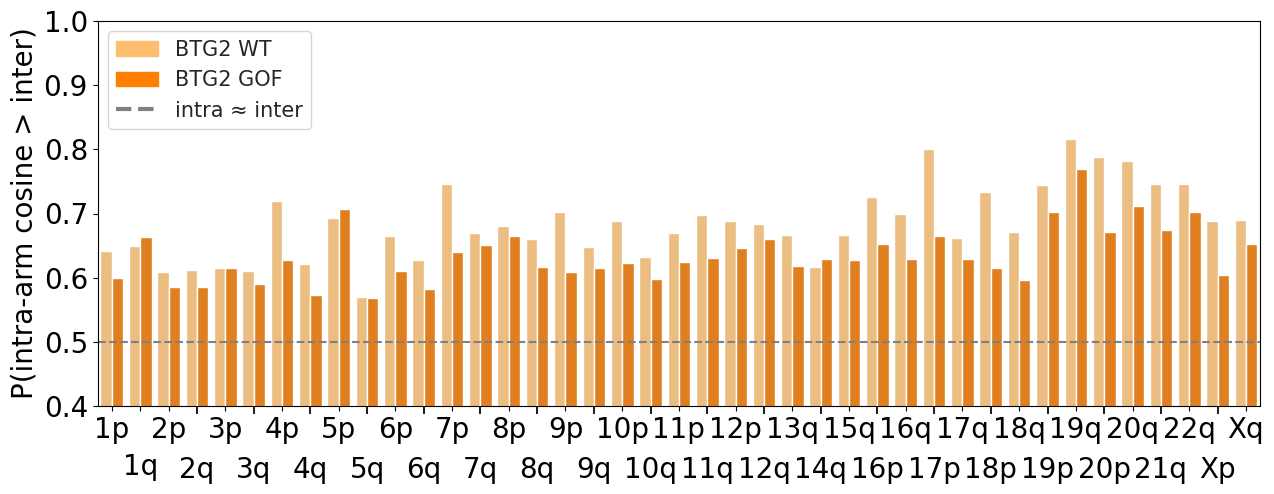

In [24]:
for g, split_type in arm_stats_d:
    print(g, split_type)

    if split_type == 'lof_vs_wt':
        lab1 = f'{g} WT'
        lab2 = f'{g} LOF'
    if split_type == 'gof_vs_wt':
        lab1 = f'{g} WT'
        lab2 = f'{g} GOF'

    tmp = arm_stats_d[(g, split_type)][0]
    tmp = tmp.reset_index().rename(columns={'prob':'P(intra-arm cosine > inter)'})
    tmp = pd.concat([tmp.query('Condition==@lab1'),
                     tmp.query('Condition==@lab2')])
    plot_bm_bar_pairs(tmp, x='Chromosome arm', y='P(intra-arm cosine > inter)', hue='Condition', 
                      lab1=lab1, lab2=lab2, i=3, legend_loc='upper left',
                      f_name=os.path.join(path, f'{g}_{split_type}_bars.svg'))